<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: [*your name*]
### ***username***: [*your username*]
### ***CID***: [*your CID*]


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

## Hyperparameter tunning notebook

Explain the steps and tests you do.

Organise it well to show how the data you present here has helped you design your final network hyperparameters (that you will use for the final training in the `yourusername_DLcw1_clean.ipynb` notebook).

add text blocks as you need

In [5]:
### add code blocks as you need
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass



Mounted at /content/drive


In [6]:
!pip install torchsummary progressbar2 livelossplot monai -q

import torch
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import Dataset
import torch.utils.data  as Data
import os, glob
from PIL import Image
from progressbar import ProgressBar
from torchvision.transforms import Compose, ToTensor, GaussianBlur, Resize, Grayscale, Lambda
from torchsummary import summary
from torchvision.utils import make_grid
from progressbar import ProgressBar
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor
from PIL import Image

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True


def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")



Cuda installed! Running on GPU 0 Tesla T4!


In [7]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [8]:
!tar -xvzf real_hands.tgz

Streaming output truncated to the last 5000 lines.
real_hands/003000.jpeg
real_hands/003001.jpeg
real_hands/003002.jpeg
real_hands/003003.jpeg
real_hands/003004.jpeg
real_hands/003005.jpeg
real_hands/003006.jpeg
real_hands/003007.jpeg
real_hands/003008.jpeg
real_hands/003009.jpeg
real_hands/003010.jpeg
real_hands/003011.jpeg
real_hands/003012.jpeg
real_hands/003013.jpeg
real_hands/003014.jpeg
real_hands/003015.jpeg
real_hands/003016.jpeg
real_hands/003017.jpeg
real_hands/003018.jpeg
real_hands/003019.jpeg
real_hands/003020.jpeg
real_hands/003021.jpeg
real_hands/003022.jpeg
real_hands/003023.jpeg
real_hands/003024.jpeg
real_hands/003025.jpeg
real_hands/003026.jpeg
real_hands/003027.jpeg
real_hands/003028.jpeg
real_hands/003029.jpeg
real_hands/003030.jpeg
real_hands/003031.jpeg
real_hands/003032.jpeg
real_hands/003033.jpeg
real_hands/003034.jpeg
real_hands/003035.jpeg
real_hands/003036.jpeg
real_hands/003037.jpeg
real_hands/003038.jpeg
real_hands/003039.jpeg
real_hands/003040.jpeg
real_h

In [9]:
import os
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        """
        Args:
            directory (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.directory = directory
        self.transform = transform
        self.images = [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)  # Convert to RGB

        if self.transform:
            image = self.transform(image)
        else:
            image = ToTensor()(image)  # Convert to tensor

        return image

# Usage
directory = "/content/drive/MyDrive/real_hands"
transform = None  # Define any transformations if needed
dataset = ImageDataset(directory, transform)


In [10]:
# Parameters
batch_size = 32
num_epochs = 50
learning_rate = 1e-3
latent_dim = 100  # Adjust based on your requirement
image_channels = 1  # Assuming X-ray images are grayscale. Change if your images are colored

transform = Compose([
    ToTensor()
    # Add any additional transformations here (e.g., Resize, Normalize)
])
handdataset = ImageDataset(directory='/content/drive/MyDrive/real_hands', transform=transform)
dataloader = Data.DataLoader(handdataset, batch_size=batch_size, shuffle=True)
print(handdataset)
print(dataloader)
print('Batch size: '+str(dataloader.batch_size))
print('Number of batches: '+str(dataloader.__len__()))  # Check the number of batches
print('Num images: '+str(dataloader.batch_size*dataloader.__len__()))
print()



Batch size: 32
Number of batches: 250
Num images: 8000



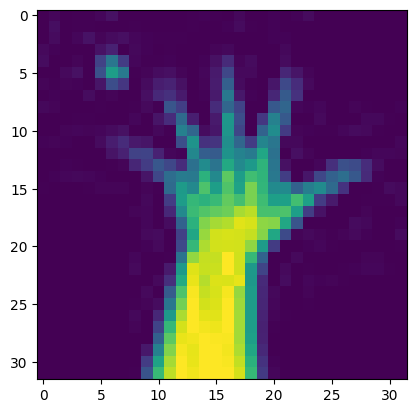

In [11]:
images = next(iter(dataloader))  # Get the first batch of images
plt.imshow(images[0].permute(1,2,0))
plt.show()



In [12]:
class VAE_Encoder(nn.Module):  # The Encoder inherits the properties of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    '''
    Class contains the Encoder (image -> latent).
    '''
    super(VAE_Encoder, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Linear(1024, 512),
        nn.ReLU()
    )

    self.layer2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU()
    )

    self.layerMu = nn.Sequential(
        nn.Linear(128, 16),
        # Does this need an activation?
    )

    self.layerSigma = nn.Sequential(
        nn.Linear(128, 16),
        # Does this need an activation?
    )

  def forward(self, x):  # Custom pytorch modules should follow this structure
    '''
    x: [float] the MNIST image
    '''

    x = torch.flatten(x, start_dim = 1)  # Reshape the input into a vector (nD to 1D)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    mu =  self.layerMu(x)
    sigma = torch.exp(self.layerSigma(x))
    return mu, sigma


In [13]:
encoder = VAE_Encoder()

images= next(iter(dataloader))  # Get the first batch of images
print(images[0].shape)  # Get the first image from the batch

encoder(images[0].unsqueeze(0))  # Are mu and sigma correct



torch.Size([1, 32, 32])


(tensor([[ 0.1076, -0.0413, -0.0017,  0.0251,  0.1096, -0.0585, -0.0958,  0.0082,
           0.0339, -0.0324, -0.0700, -0.0170, -0.0007,  0.0069,  0.0660, -0.0387]],
        grad_fn=<AddmmBackward0>),
 tensor([[0.9897, 0.9585, 1.0233, 0.9351, 1.0094, 0.9303, 0.9363, 1.0637, 1.0238,
          0.9075, 0.9710, 1.0129, 0.9350, 0.9860, 0.9371, 1.0529]],
        grad_fn=<ExpBackward0>))

In [14]:
class VAE_Decoder(nn.Module):  # The Encoder inherits the properties of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(VAE_Decoder, self).__init__()

    self.layerLatent = nn.Sequential(
        nn.Linear(16, 128),
        # Does the latent vector have an activation?
    )

    self.layer1 = nn.Sequential(
        nn.Linear(128, 256),
        nn.ReLU()
    )

    self.layer2 = nn.Sequential(
        nn.Linear(256, 512),
        nn.ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.Sigmoid() # Does this need an activation?
    )

  def forward(self, z):  # Custom pytorch modules should follow this structure
    '''
    x: [float] the MNIST image
    '''

    z = self.layerLatent(z)
    z = self.layer1(z)
    z = self.layer2(z)
    z = self.layer3(z)
    return z.reshape((-1,1,32,32))  # Reshape the vector into an image



In [15]:
class VAE(nn.Module):
  def __init__(self, device):
    '''
    Class combines the Encoder and the Decoder with a VAE latent space.
    '''
    super(VAE, self).__init__()
    self.device = device
    self.encoder = VAE_Encoder()
    self.decoder = VAE_Decoder()
    self.distribution = torch.distributions.Normal(0, 1)  # Sample from N(0,1)

  def sample_latent_space(self, mu, sigma):
    z = mu + sigma * self.distribution.sample(mu.shape).to(self.device)  # (1) Sample the latent distribution
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()  # A term, which is required for regularisation
    return z, kl_div

  def forward(self, x):
    '''
    x - [float] A batch of images from the data-loader
    '''

    mu, sigma = self.encoder(x)  ## (1) Generate the latent vectors Mu and Sigma
    z, kl_div = self.sample_latent_space(mu, sigma)  ## (2) Generate the latent vector sample
    z = self.decoder(z)  ## (3) Generate the reconstructed image
    return z, kl_div

print('done')

done


torch.Size([1, 32, 32])


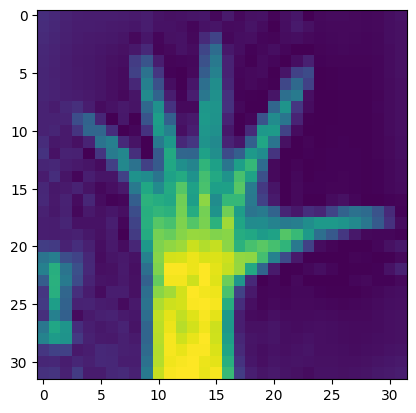

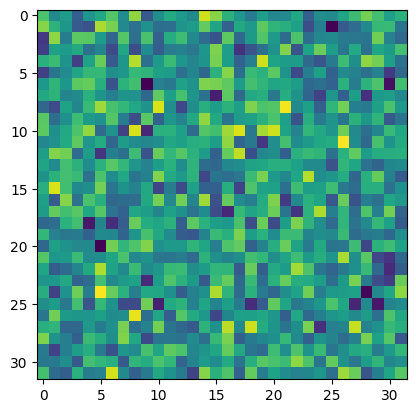

In [16]:
vae = VAE('cpu')

images= next(iter(dataloader))  # Get the first batch of images
print(images[0].shape)  # Get the first image from the batch
recon, _ = vae(images[10].unsqueeze(0))  # Are mu and sigma correct

plt.figure(); plt.imshow(images[0].squeeze())
plt.figure(); plt.imshow(recon.cpu().detach().squeeze())

In [26]:
from tqdm import tqdm
def train(autoencoder, data, kl_div_on=True, epochs=10, device='cpu'):
  opt = torch.optim.Adam(autoencoder.parameters())
  for epoch in range(epochs):  # Run data over numerous epochs
    for batch in tqdm(data):  # Iterate over the batches of images and labels
      batch = batch.to(device)  # Send batch of images to the GPU
      opt.zero_grad()  # Set optimiser grad to 0
      x_hat, KL = autoencoder(batch)  # Generate predicted images (x_hat) by running batch of images through autoencoder
      loss = ((batch - x_hat)**2).sum() + KL  # Calculate combined loss
      loss.backward()  # Back-propagate
      opt.step()  # Step the optimiser
  return autoencoder  # Return the trained autoencoder (for later analysis)

device = 'cuda'

dims_latent = 2  # Maybe increase this an try the t-sne algorithm for visualisation?!
vae = VAE(device).to(device)
vae = train(vae, dataloader, epochs=10, device=device)

print('done')

100%|██████████| 250/250 [00:10<00:00, 23.83it/s]

done


torch.Size([32, 1, 32, 32])


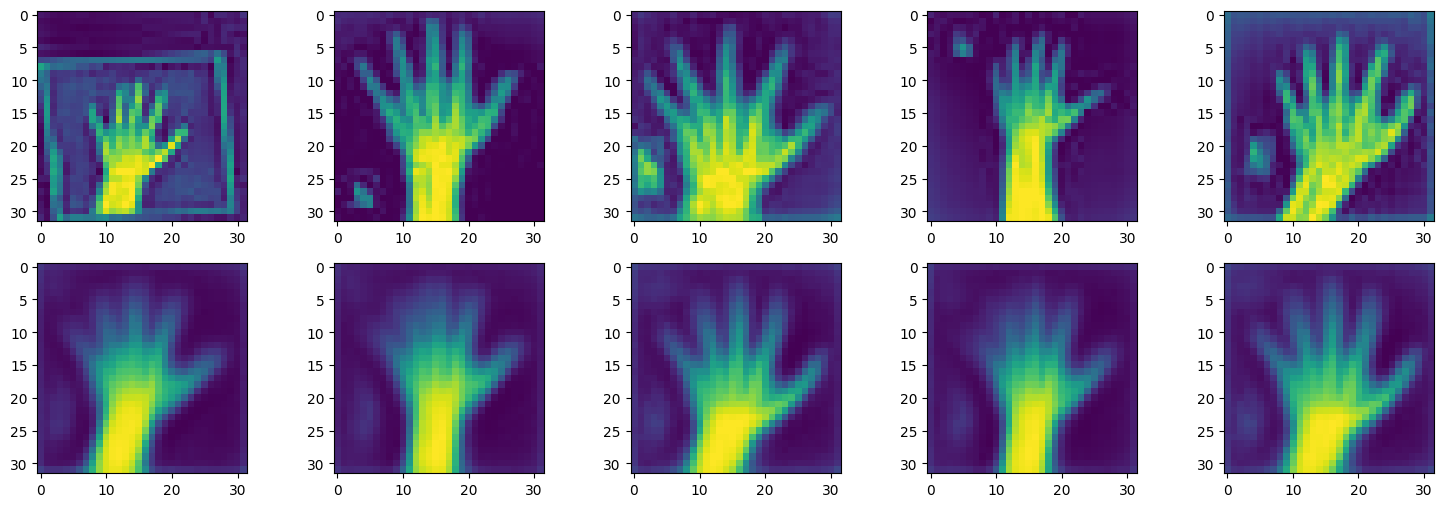

In [27]:
images= next(iter(dataloader))  # Get the first batch of images
print(images.shape)  # Get the first image from the batch

_, ax = plt.subplots(2, 5, figsize=[18.5, 6])
for n, idx  in enumerate(torch.randint(0,images.shape[0], (5,))):
  recon, _ = vae(images[idx].unsqueeze(0).cuda())  # Are mu and sigma correct
  ax[0, n].imshow(images[idx].squeeze())
  ax[1, n].imshow(recon.cpu().detach().squeeze())

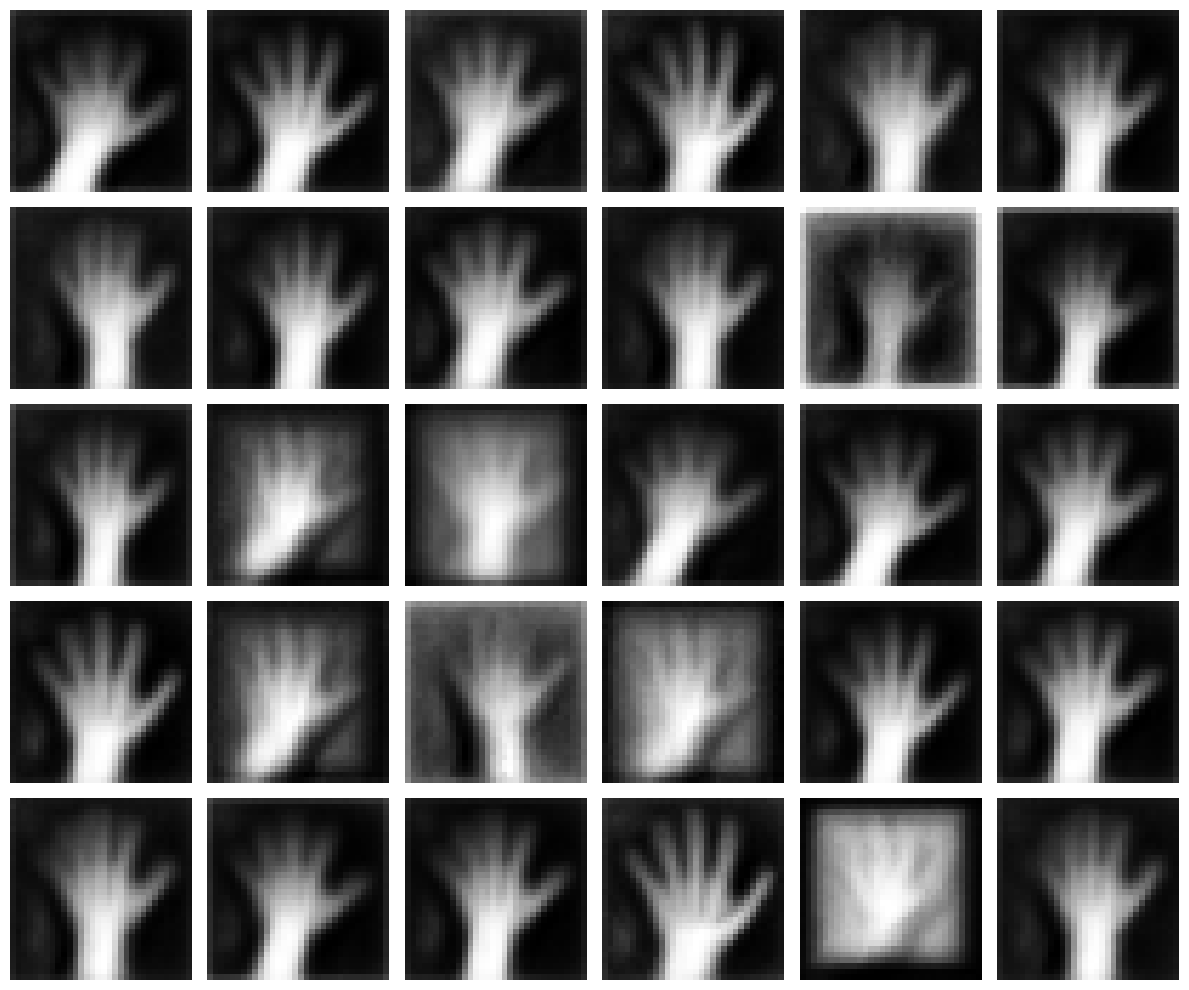

In [28]:
import torch
import matplotlib.pyplot as plt

# Instantiate your VAE model and move it to the desired device
# Replace 'device' with 'cuda' or 'cpu' as appropriate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Ensure the VAE is in evaluation mode
vae.eval()

# Set the number of images to generate and the latent space dimension
num_images = 30
latent_dim = 16  # Replace this with your actual latent space dimension

# Sample random points in the latent space from a standard normal distribution
random_latent_vectors = torch.randn(num_images, latent_dim).to(device)

# Decode the latent vectors to generate images
# Since we only need the decoder here, we can directly use it
generated_images = vae.decoder(random_latent_vectors)

# Move generated images to CPU and detach from computation graph for visualization
generated_images = generated_images.cpu().detach()

# Plotting the generated images
fig, axes = plt.subplots(5, 6, figsize=(12, 10))  # Adjust the subplot grid as needed
axes = axes.flatten()

for img, ax in zip(generated_images, axes):
    # Assuming the images are single-channel (e.g., grayscale)
    # Adjust the following line if your images are in a different format
    img = img.squeeze().numpy()

    ax.imshow(img, cmap='gray')  # Use cmap='gray' for grayscale images
    ax.axis('off')

plt.tight_layout()
plt.show()
